# Real-time informed pseudotime on mouse embryonic fibroblasts

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from scipy.sparse import load_npz
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axisartist.axislines import AxesZero

import cellrank as cr
import scanpy as sc
import scvelo as scv
from scanpy.tools._dpt import DPT

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")
scv.settings.plot_prefix = ""

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "realtime_kernel" / "mef", exist_ok=True)

## Function definitions

In [5]:
def get_symmetric_transition_matrix(transition_matrix):
    """Symmetrize transition matrix."""
    sym_mat = (transition_matrix + transition_matrix.T) / 2

    # normalise transition matrix
    row_sums = sym_mat.sum(axis=1).A1
    sym_mat.data = sym_mat.data / row_sums[sym_mat.nonzero()[0]]

    return sym_mat

## Data loading

In [6]:
adata = cr.datasets.reprogramming_schiebinger(DATA_DIR / "mef" / "reprogramming_schiebinger.h5ad")
adata = adata[adata.obs["serum"] == "True"].copy()

adata.obs["day"] = adata.obs["day"].astype(float)
adata.uns["cell_sets_colors"] = sns.color_palette("colorblind").as_hex()[: len(adata.obs["cell_sets"].cat.categories)]

adata

DEBUG: Loading dataset from `'/vol/storage/philipp/code/cellrank2_reproducibility/data/mef/reprogramming_schiebinger.h5ad'`


AnnData object with n_obs × n_vars = 165892 × 19089
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    var: 'highly_variable', 'TF'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'

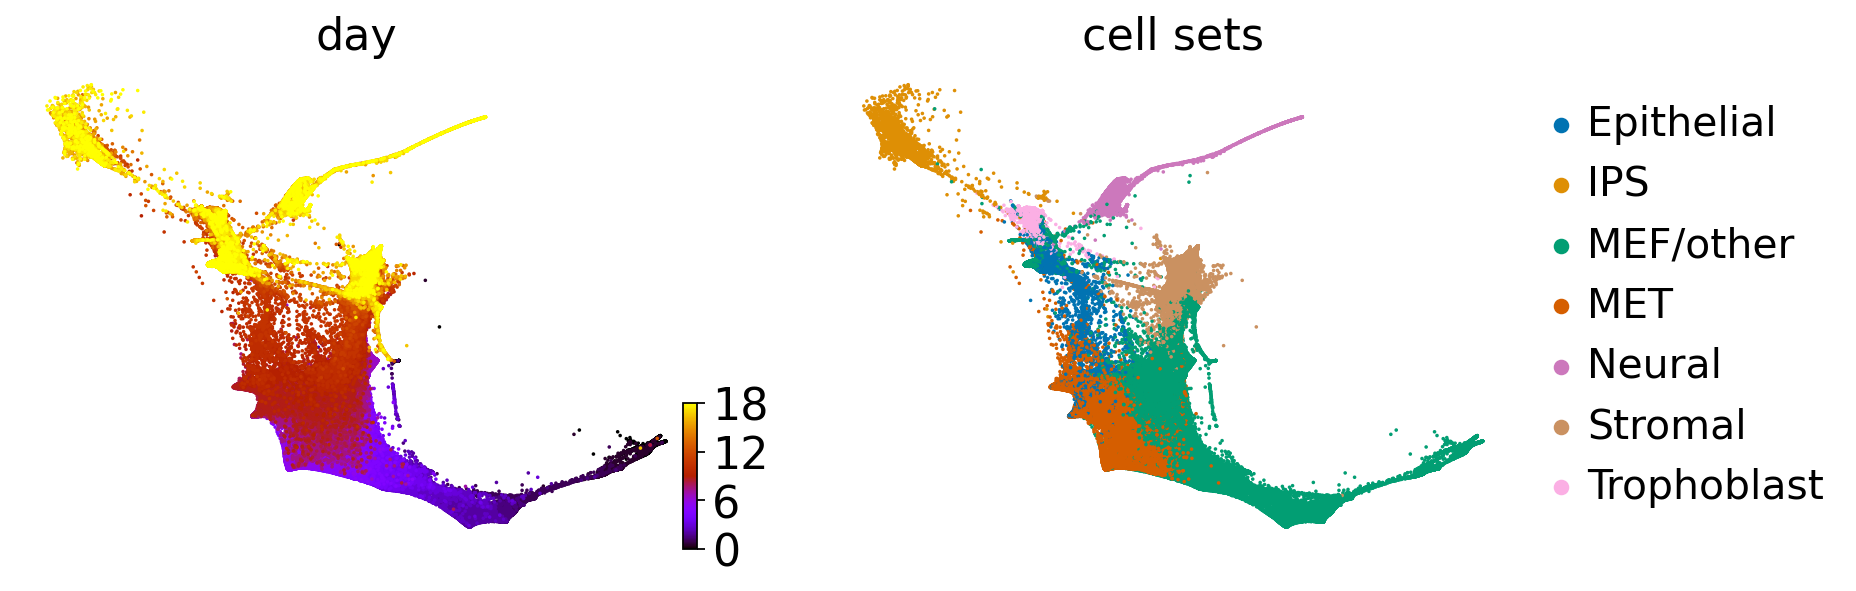

In [7]:
scv.pl.scatter(adata, basis="force_directed", c=["day", "cell_sets"], legend_loc="right", cmap="gnuplot")

## Data pre-processing

In [8]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)


In [9]:
sc.pp.neighbors(adata, random_state=0)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:02:52)


## Pseudotime construction

In [10]:
adata.obs["day"] = adata.obs["day"].astype(float).astype("category")

In [11]:
rtk = cr.kernels.RealTimeKernel.from_wot(adata, path=DATA_DIR / "mef" / "wot_tmaps", time_key="day")
rtk.transition_matrix = load_npz(DATA_DIR / "mef" / "transition_matrices" / "all_connectivities.npz")

Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.0', '.h5ad'].
Only considering the two last: ['.5', '.

In [12]:
dpt = DPT(adata=adata, neighbors_key="neighbors")
dpt._transitions_sym = get_symmetric_transition_matrix(rtk.transition_matrix)
dpt.compute_eigen(n_comps=15, random_state=0)

adata.obsm["X_diffmap"] = dpt.eigen_basis
adata.uns["diffmap_evals"] = dpt.eigen_values

    eigenvalues of transition matrix
    [1.0001833  0.99828625 0.9944004  0.990108   0.98900795 0.9872317
     0.97979957 0.97734815 0.969743   0.96797746 0.9661498  0.9550961
     0.9499476  0.94606787 0.94111   ]


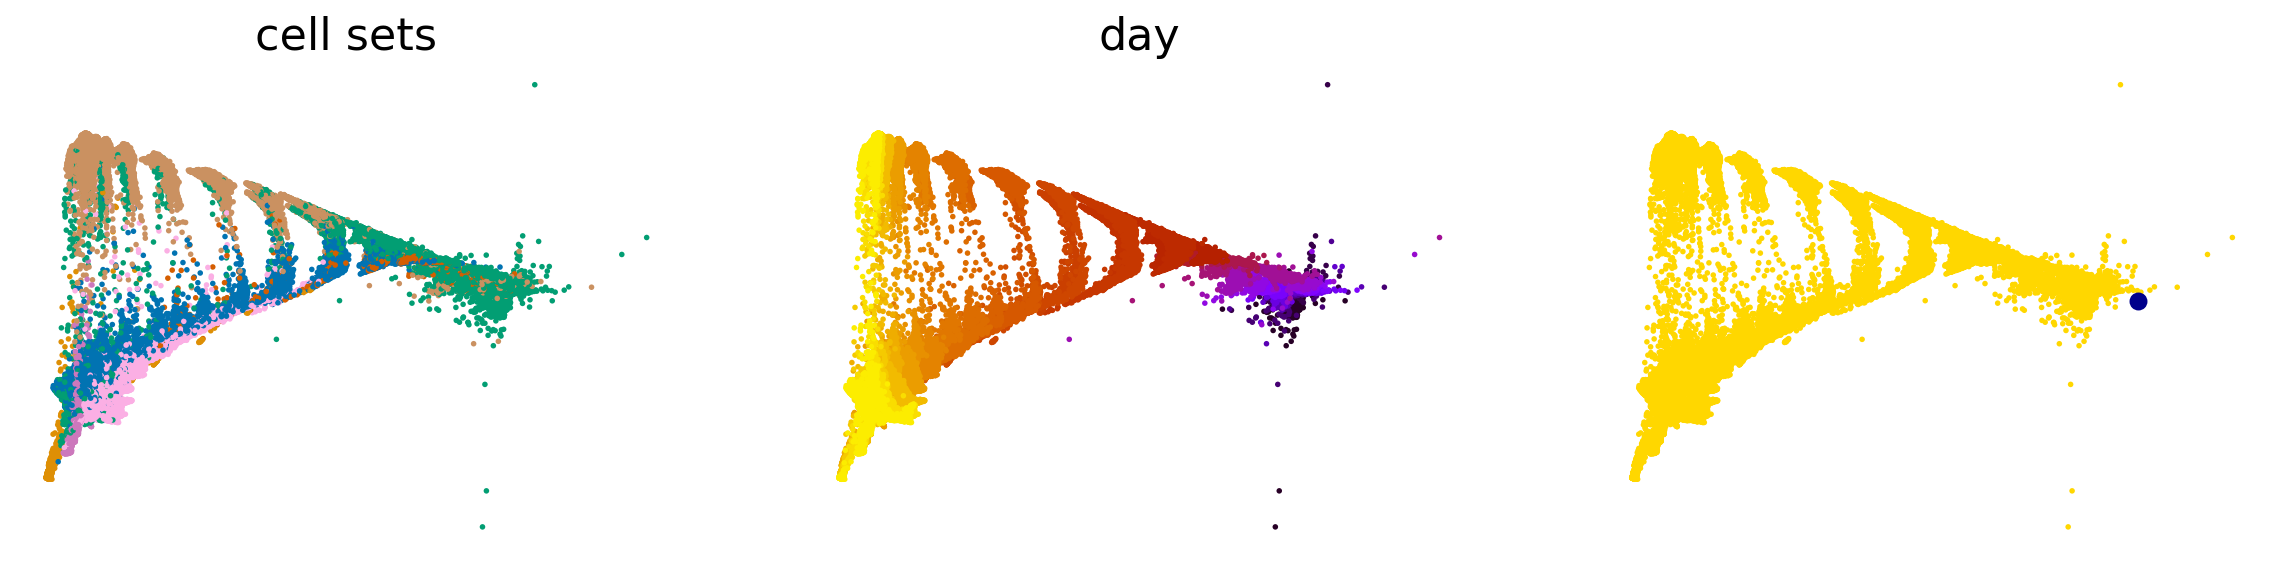

In [13]:
"""
df = pd.DataFrame(
    {
        'diff_comp': adata.obsm['X_diffmap'][:, 1],
        'cell_type': adata.obs['cell_sets'].values,
        'day': adata.obs['day'].values,
    }
).reset_index().rename({'index': 'obs_id'}, axis=1)
df = df.loc[df['day'] == "0.0", "diff_comp"]
root_idx = df.index[df.argmax()]
"""

root_idx = 1210
scv.pl.scatter(adata, basis="diffmap", color=["cell_sets", "day", root_idx], components=["1, 2"], size=25)

In [14]:
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


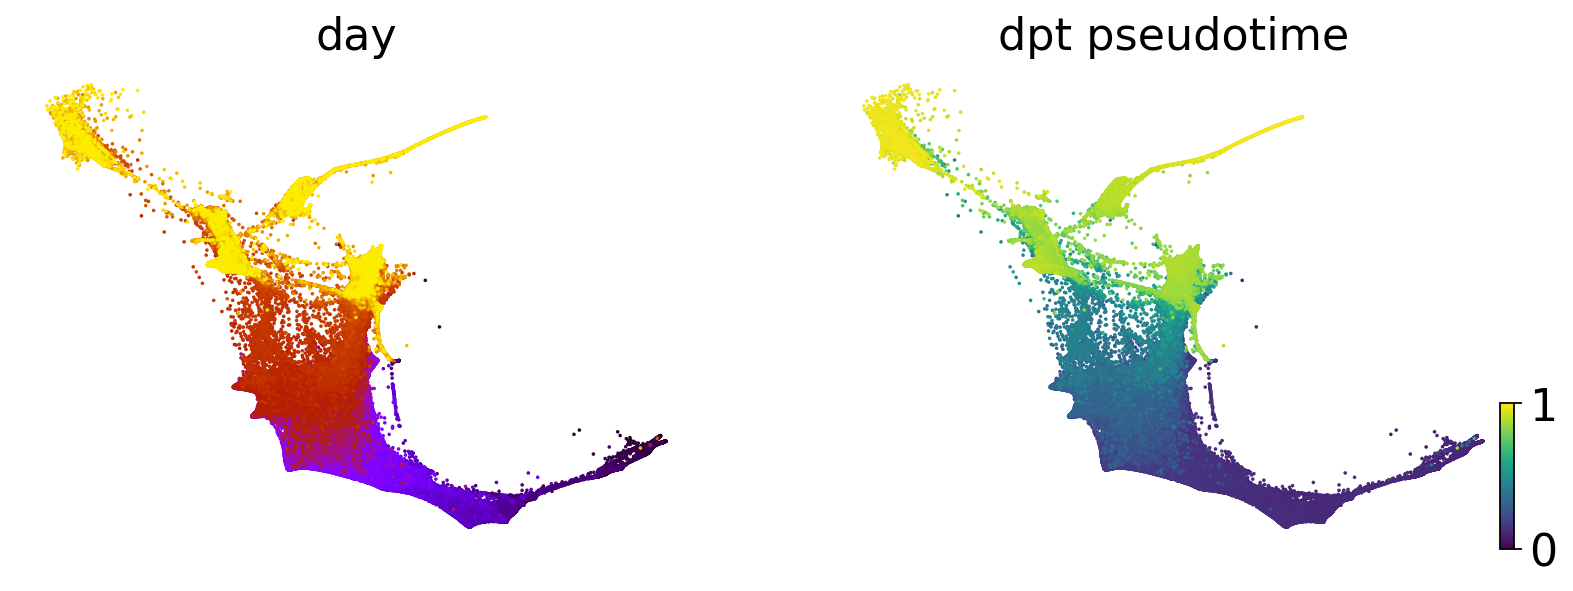

In [15]:
scv.pl.scatter(adata, basis="force_directed", c=["day", "dpt_pseudotime"], legend_loc="none", cmap="viridis")

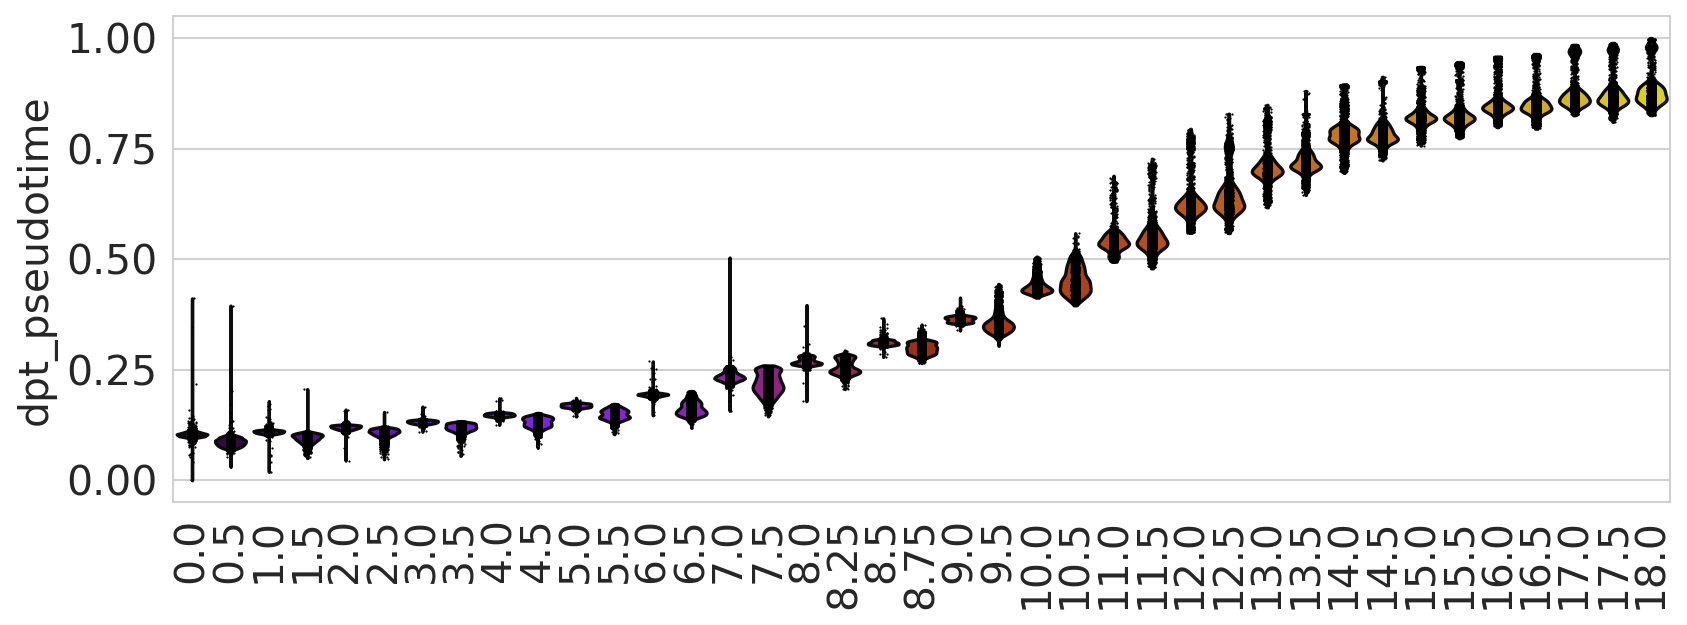

In [16]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 4))
sc.pl.violin(adata, keys=["dpt_pseudotime"], groupby="day", rotation=90, ax=ax, title="", legend_loc="none")

if SAVE_FIGURES:
    ax.hlines([0, 0.25, 0.5, 0.75, 1], xmin=-0.75, xmax=39, linestyles="solid", colors="black", zorder=0)
    ax.axis("off")
    fig.savefig(
        FIG_DIR / "realtime_kernel" / "mef" / "real_time_informed_pseudotime_vs_time_point_labeled.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

sns.reset_orig()

In [17]:
spearmanr(adata.obs["dpt_pseudotime"].values, adata.obs["day"].astype(float).values)

SpearmanrResult(correlation=0.9806606782007906, pvalue=0.0)

## Terminal state estimation

In [18]:
g = cr.estimators.GPCCA(rtk)

In [19]:
g.compute_schur(n_components=10)
g.plot_spectrum(real_only=True)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:16)


Computing `4` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:21)


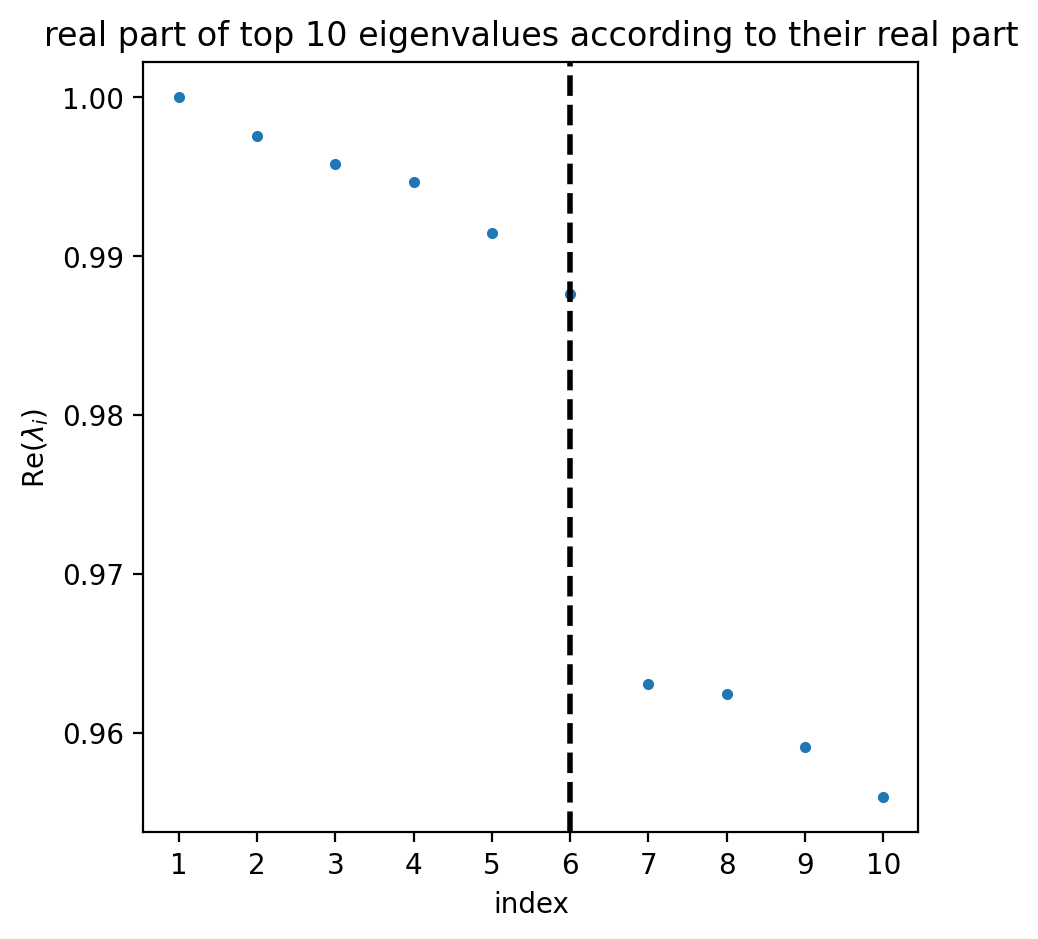

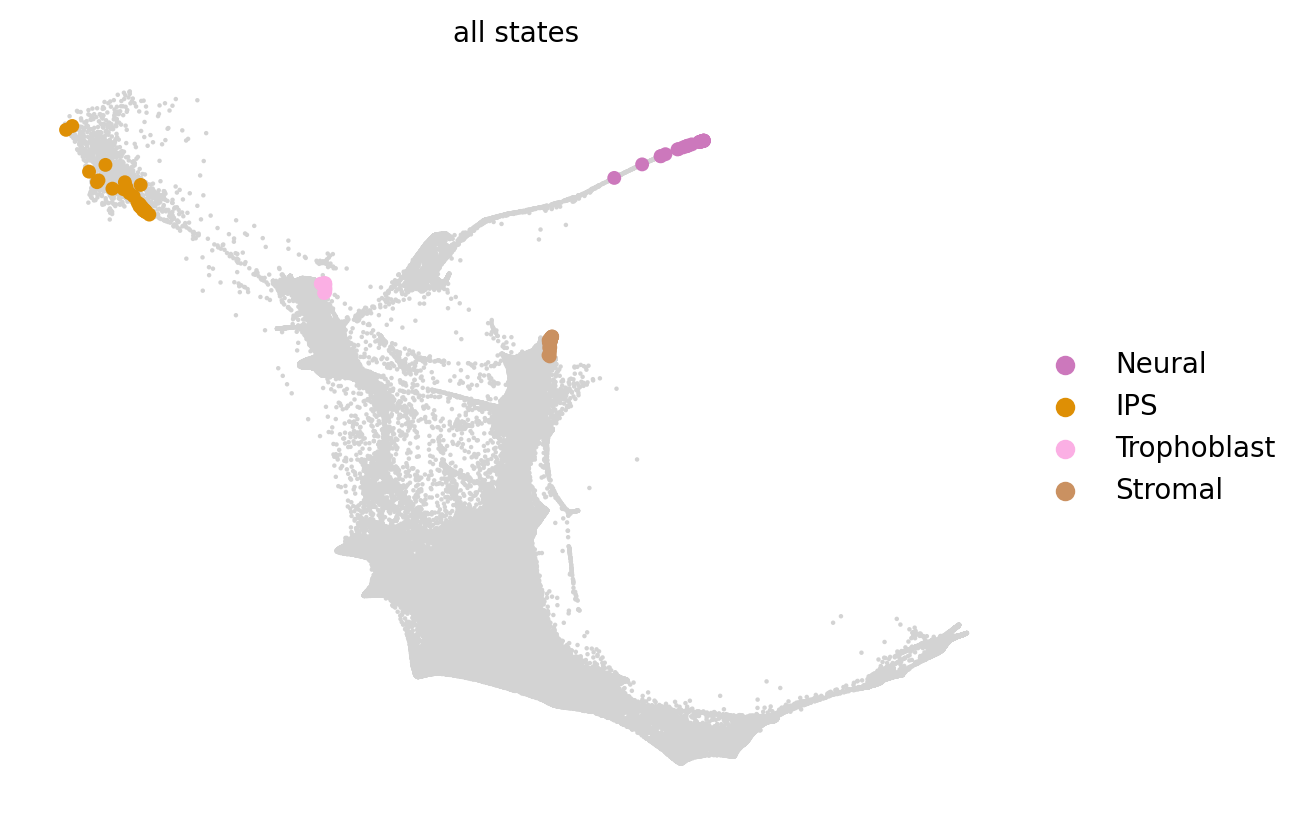

In [20]:
g.compute_macrostates(n_states=4, cluster_key="cell_sets")
g.plot_macrostates(which="all", basis="force_directed", legend_loc="right", s=100)

In [21]:
g.set_terminal_states(states=["IPS", "Neural", "Trophoblast", "Stromal"])

DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


GPCCA[kernel=RealTimeKernel[n=165892], initial_states=None, terminal_states=['IPS', 'Neural', 'Stromal', 'Trophoblast']]

Computing fate probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-06`


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:10)


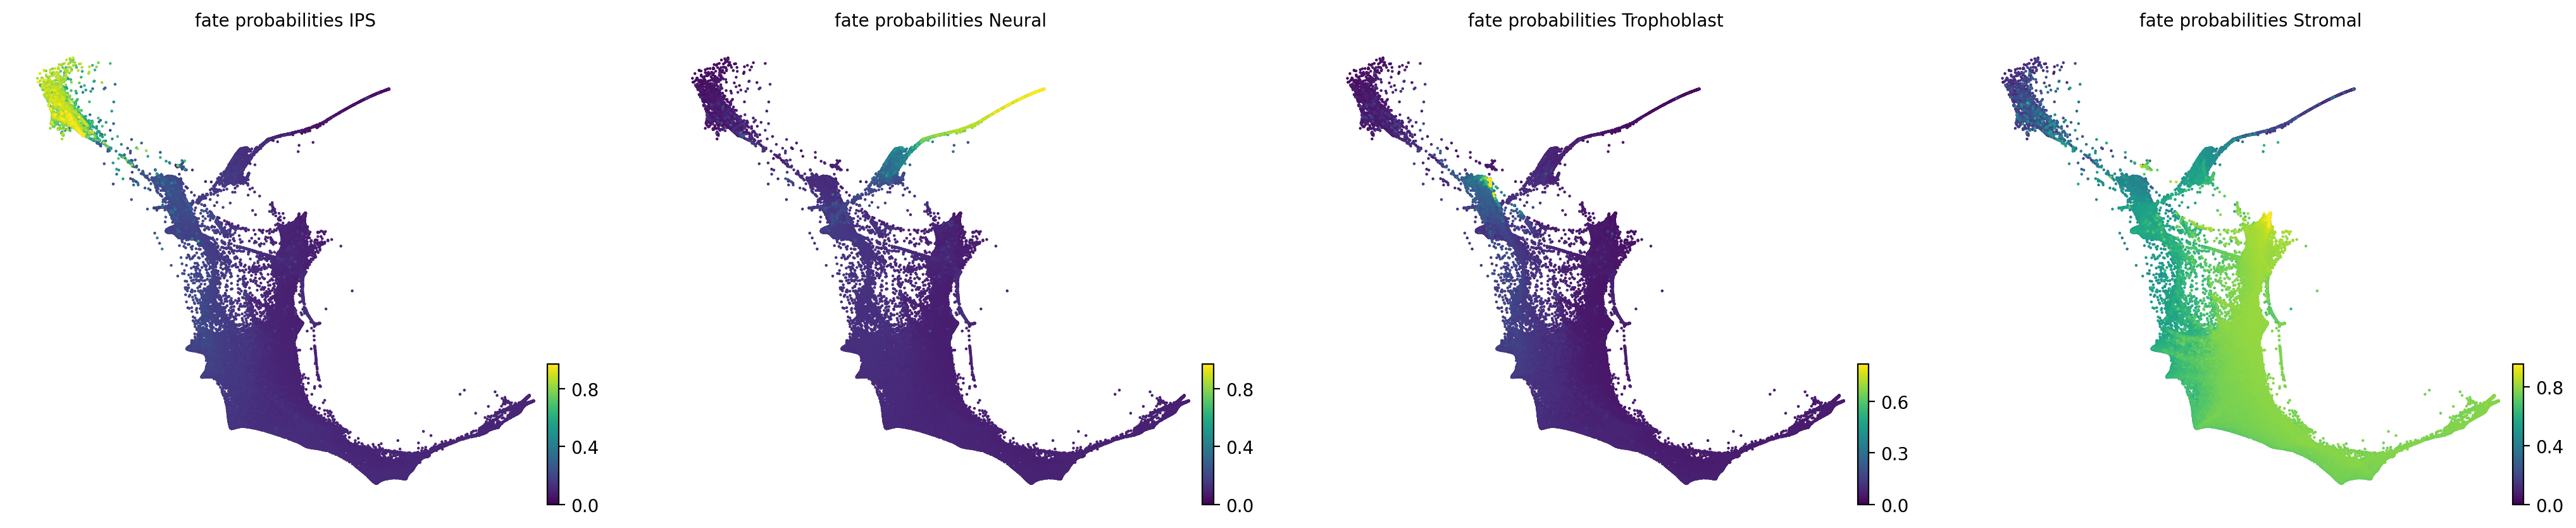

In [22]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(basis="force_directed", same_plot=False)

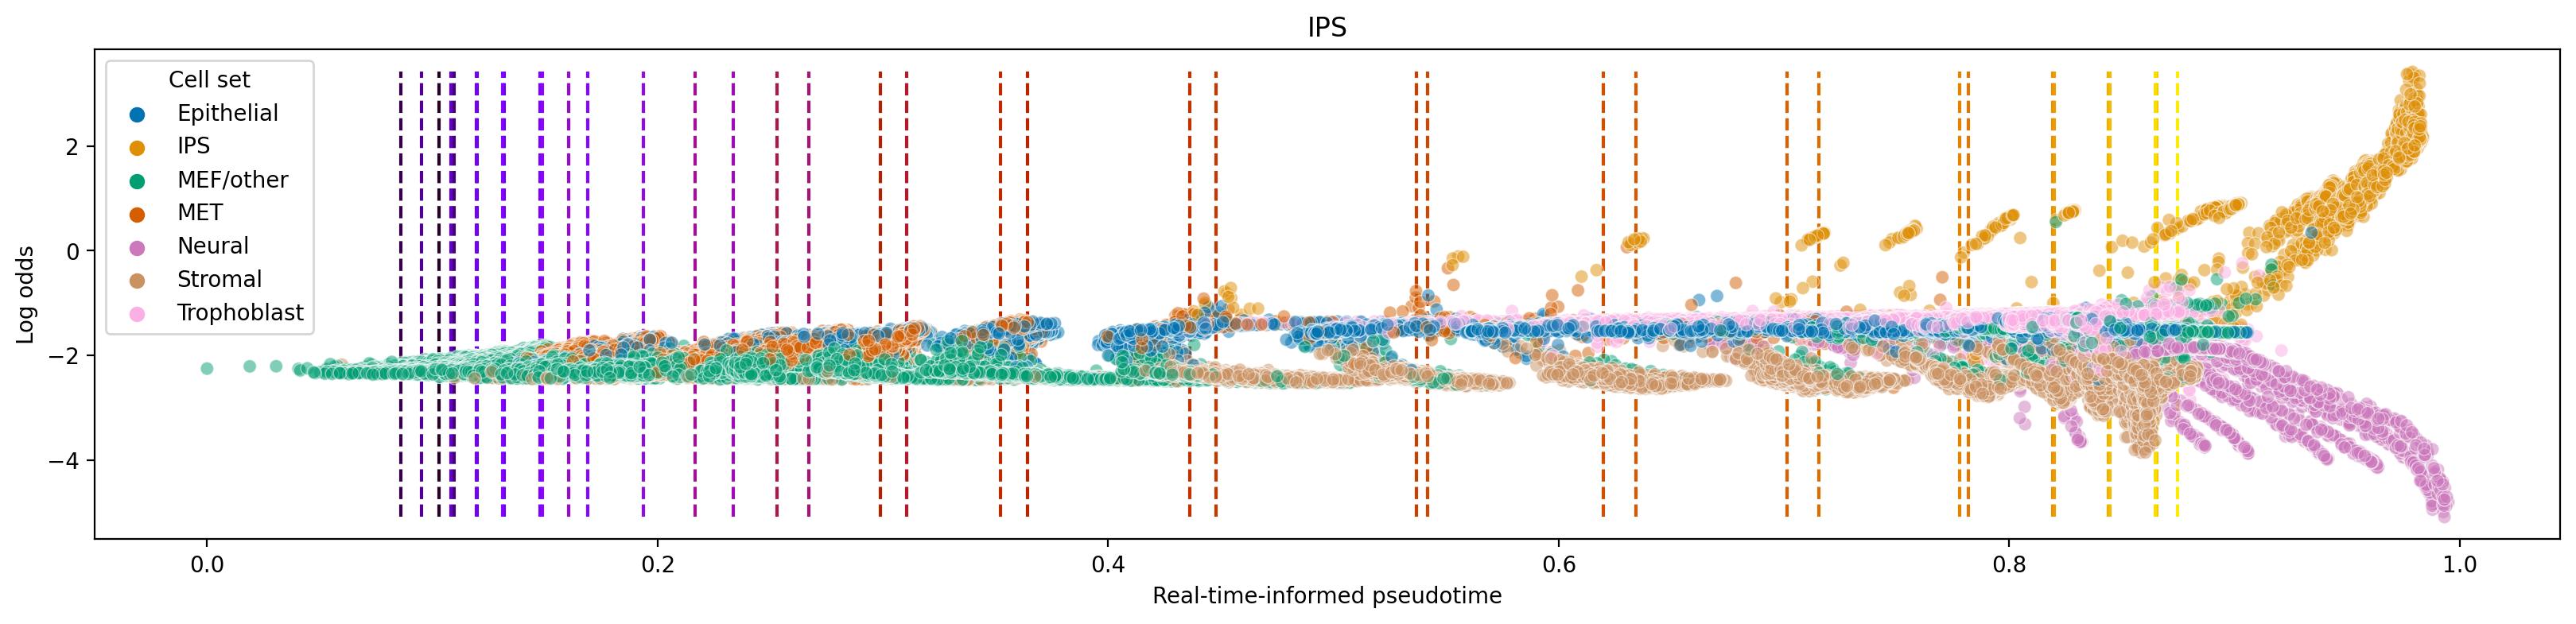

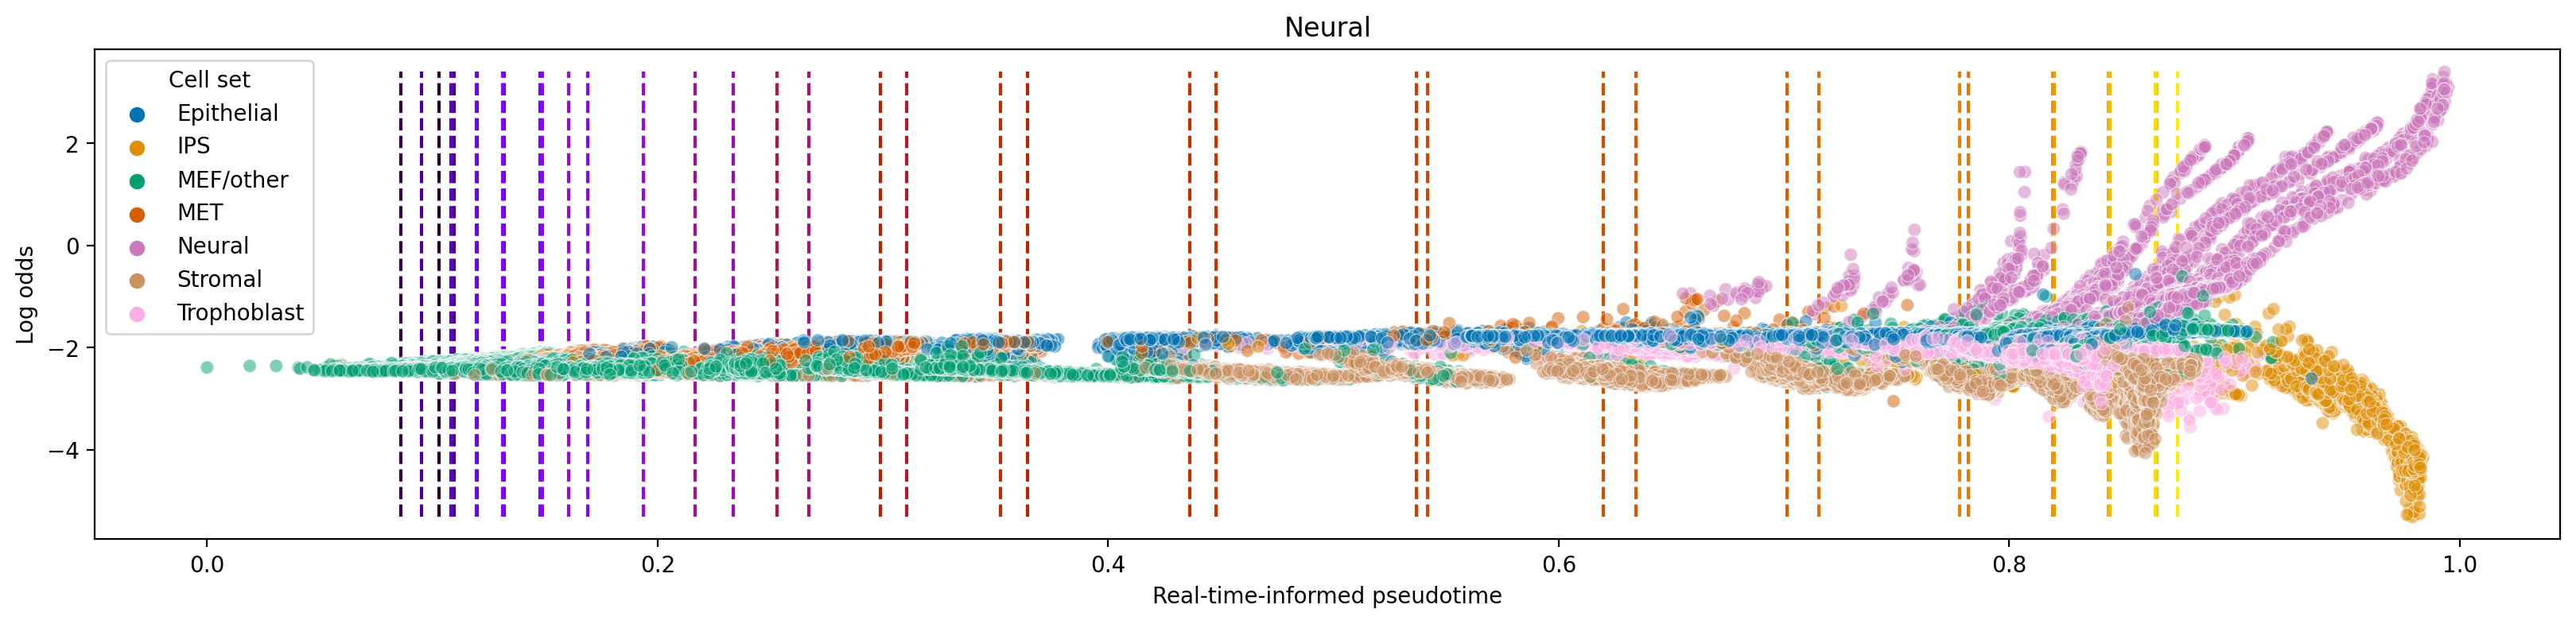

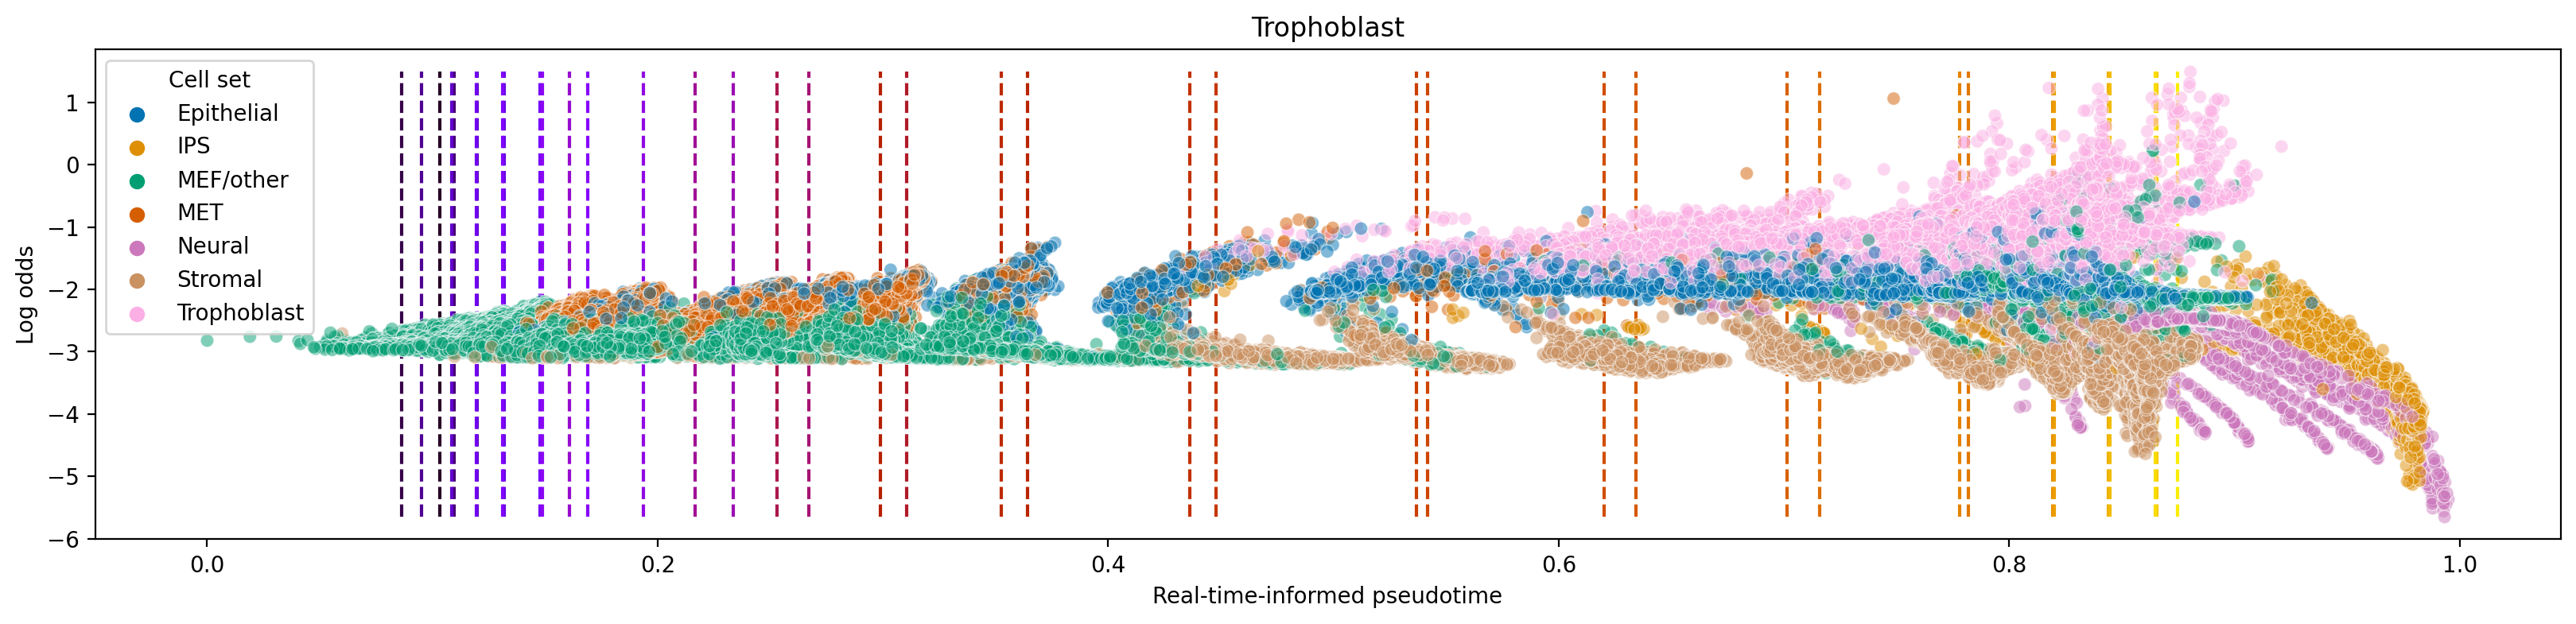

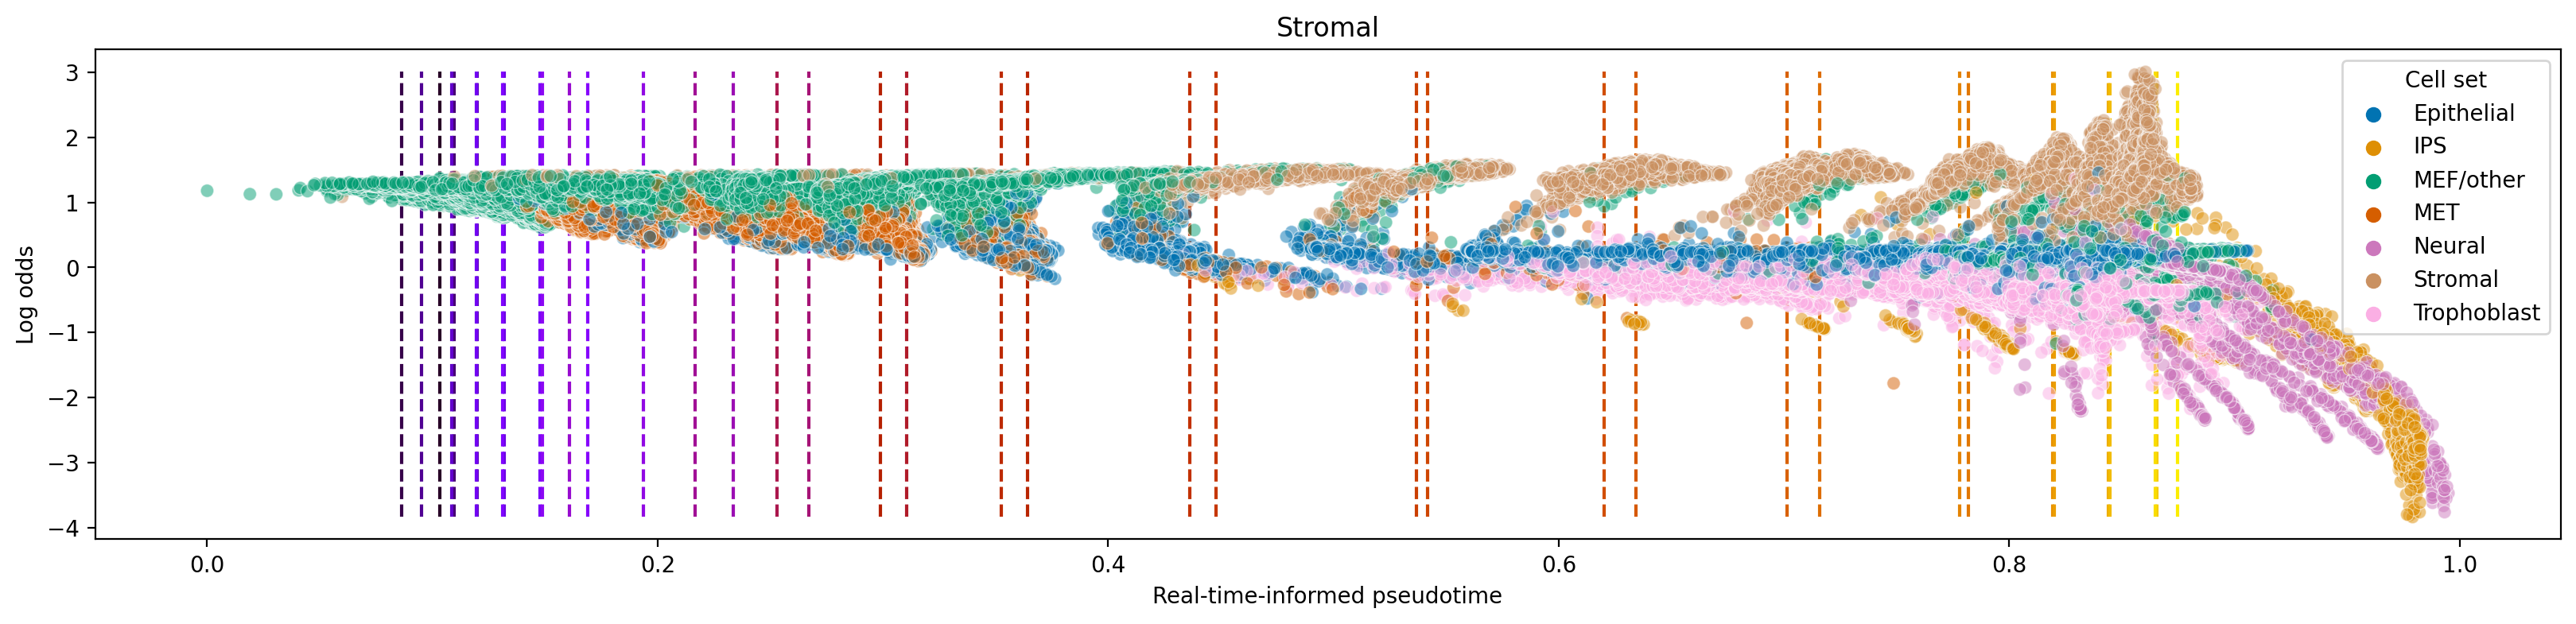

In [23]:
palette = dict(zip(adata.obs["cell_sets"].cat.categories, adata.uns["cell_sets_colors"]))
median_pt = adata.obs[["day", "dpt_pseudotime"]].groupby("day").median()["dpt_pseudotime"].values

for terminal_state in g.terminal_states.cat.categories:
    fate_prob = adata.obsm["lineages_fwd"][terminal_state].X.squeeze()
    ref_fate_prob = 1 - fate_prob
    log_odds = np.log(np.divide(fate_prob, 1 - fate_prob, where=fate_prob != 1, out=np.zeros_like(fate_prob)) + 1e-12)
    df = pd.DataFrame(
        {
            "Log odds": log_odds,
            "Real-time-informed pseudotime": adata.obs["dpt_pseudotime"].values,
            "Cell set": adata.obs["cell_sets"],
        }
    )
    df = df.loc[(fate_prob != 0) & (fate_prob != 1), :]

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.vlines(
        median_pt,
        ymin=df["Log odds"].min(),
        ymax=df["Log odds"].max(),
        linestyles="dashed",
        colors=adata.uns["day_colors"],
        zorder=0,
    )
    sns.scatterplot(
        data=df,
        x="Real-time-informed pseudotime",
        y="Log odds",
        hue="Cell set",
        palette=palette,
        alpha=0.5,
        ax=ax,
    )
    ax.set_title(terminal_state)
    plt.show()

    if SAVE_FIGURES:
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(axes_class=AxesZero)

        for direction in ["xzero", "yzero"]:
            ax.axis[direction].set_axisline_style("-|>")
            ax.axis[direction].set_visible(True)
            ax.axis[direction].set_zorder(0)
        ax.axis["xzero"].set_ticklabel_direction("-")
        ax.axis["yzero"].set_ticklabel_direction("+")
        for direction in ["left", "right", "bottom", "top"]:
            ax.axis[direction].set_visible(False)

        ax.vlines(
            median_pt,
            ymin=df["Log odds"].min(),
            ymax=df["Log odds"].max(),
            linestyles="dashed",
            colors=adata.uns["day_colors"],
            zorder=0,
        )
        sns.scatterplot(
            data=df,
            x="Real-time-informed pseudotime",
            y="Log odds",
            hue="Cell set",
            palette=palette,
            alpha=0.5,
            ax=ax,
        )

        ax.get_legend().remove()
        ax.set_xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=[])
        ax.set_yticks(ticks=[-4, -2, 0, 2], labels=[])

        ax.set(xlabel=None, ylabel=None)

        fig.savefig(
            FIG_DIR / "realtime_kernel" / "mef" / f"rtk_log_odds_vs_pt-{terminal_state.lower()}_lineage.pdf",
            format="pdf",
            transparent=True,
            bbox_inches="tight",
            pad_inches=0.2,
        )

        plt.show()